Code to analyze the Beta diversity

In [1]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import pandas as pd
import qiime2 as q2
from skbio import OrdinationResults
from qiime2 import Visualization
from seaborn import scatterplot
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#all variables
Data_raw='Data/raw'
Data_classified='Data/classified'
Data_diversity='Data/diversity'

<div style="background-color: skyblue; padding: 10px;">
    Titles
    </div>
<div style="background-color: aliceblue; padding: 10px;">
    Results

## Creating the necessary files  
<div style="background-color: skyblue; padding: 10px;">


### Creating the files on all metadata

Adjusting merged_output.tsv to adapt for analysis without problems (no spaces in column titles)

In [ ]:
df = pd.read_csv(f'{Data_raw}/merged_output.tsv', sep='\t')
# Keep first column name, modify the rest
new_columns = [df.columns[0]] + [col.replace(' ', '_').replace('/', '_') for col in df.columns[1:]]
df.columns = new_columns
df.to_csv(f'{Data_raw}/merged_output_usable.tsv', sep='\t', index=False)

In [5]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Data/diversity/core-metrics-results-merged/jaccard

The following code was then submitted as a job on Euler, due to too little memory capacity on Jupyterhub

### Creating files on just sourdough data

First filtering the coresponding tables

In [6]:
!qiime feature-table filter-samples \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv  \
  --p-where "sample_type='sourdough'" \
  --o-filtered-table $Data_classified/table-filtered-sourdough_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-sourdough_only.qza


In [7]:
!qiime feature-table filter-seqs \
  --i-data $Data_classified/rep-seqs-filtered.qza \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --o-filtered-data $Data_classified/rep-seqs-filtered-sourdough_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: Data/classified/rep-seqs-filtered-sourdough_only.qza


Creating the metrics files

In [8]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged-sourdough-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged-sourdough-only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-sourdough-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-sourdough-only/bray_curtis_di

In [9]:
!qiime kmerizer core-metrics \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --i-sequences $Data_classified/rep-seqs-filtered-sourdough_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/kmerizer-results-merged-sourdough-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/kmerizer-results-merged-sourdough-only/rarefied_table.qza
Saved FeatureTable[Frequency] to: Data/diversity/kmerizer-results-merged-sourdough-only/kmer_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/kmerizer-results-merged-sourdough-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/kmerizer-results-merged-sourdough-only/shannon_vector.qza
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza
Saved PCoAResu

### Creating files on just hand data

Filtering first

In [10]:
!qiime feature-table filter-samples \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv  \
  --p-where "sample_type='hand_swabs'" \
  --o-filtered-table $Data_classified/table-filtered-hand_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-hand_only.qza


In [11]:
!qiime feature-table filter-seqs \
  --i-data $Data_classified/rep-seqs-filtered.qza \
  --i-table $Data_classified/table-filtered-hand_only.qza \
  --o-filtered-data $Data_classified/rep-seqs-filtered-hand_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: Data/classified/rep-seqs-filtered-hand_only.qza


Creating the metric files

In [12]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered-hand_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged-hand-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged-hand-only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-hand-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-hand-only/bray_curtis_distance_matrix.qza
Saved PCoARe

The following job was submitted on Euler, due to too little memory capacity on Jupyterhub

### Filter distance matrix for people who fileld out survey

In [ ]:
df = pd.read_csv("Data/raw/merged_output_usable.tsv", sep="\t")

columns_to_check = ["start_time", "completion_time"]

df_filtered = df.dropna(subset=columns_to_check)

df_filtered.to_csv("Data/diversity/filtered-metadata/meta_survey.tsv", sep="\t", index=False)

In [13]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza


In [14]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza


## Analysis of whole Metadata ITS
<div style="background-color: skyblue; padding: 10px;">


### Initial plots

In [15]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/scatterplot.qzv")

<visualization: Visualization uuid: c5f51218-a731-424a-aef5-2345875b2afa>

<div style="background-color: aliceblue; padding: 10px;">
    
- Hand swabs and sourdough communities show different sets of fungis and different relative abundance  
- when doing day as y-axis and bray-curtis as x-axis there seems to be more and more similarities for the sourdoughs to the hand over time  
- there appears to be no difference between right & left hand

In [16]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: bca58d97-305a-4158-81a7-722bf4f3cfdc>

### Comparison of the hand & sourdough environment

#### Filtering just on hand & sourdough

In [44]:
df = pd.read_csv("Data/raw/merged_output_usable.tsv", sep="\t")

major_types = ["hand_swabs", "sourdough"]

df_filtered = df[df["sample_type"].isin(major_types)]

df_filtered.to_csv("Data/diversity/filtered-metadata/meta_handdough.tsv",sep="\t", index=False)

In [45]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza


In [46]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza


#### Checking difference between hand & sourdough

Bray-curtis

In [51]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough.tsv \
    --m-metadata-column sample_type \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv


In [52]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv")

<visualization: Visualization uuid: 0fefee44-d554-4261-9629-f1d85221a4ef>

Jaccard

In [53]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough.tsv \
    --m-metadata-column sample_type \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-sample_type-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-sample_type-significance.qzv


In [54]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-sample_type-significance.qzv")

<visualization: Visualization uuid: 5f2dae1c-41a7-4ee4-9316-c90b5945183b>

<div style="background-color: aliceblue; padding: 10px;">

- Comparison of the sample types (handswabs vs sourdough) shows a significant difference in the composition and abundance (bray curtis: p value of 0.001, q-value of 0.001 & pseudo F value of 253.777534; jaccard metric: p of 0.001, q-value of 0.001 and pseudo F-value of 100.950748) 
- which indicates a high proportion of features that are not shared between hand and sourdough overall

#### Comparison of hand & sourdough over time

In [62]:
df = pd.read_csv("Data/raw/merged_output_usable.tsv", sep="\t")

major_types = ["hand_swabs", "sourdough"]
df = df[df["sample_type"].isin(major_types)]

df = df[df["day"].isin([7.0, 21.0])]

df["person_day"] = df["person-id"].astype(str) + "_" + df["day"].astype(str)

df.to_csv("Data/diversity/filtered-metadata/meta_handdough_pairwise.tsv", sep="\t", index=False)

Replicates were handeled as random because hand swabs for left & right were generated & down below shown no statistical significant difference between hand composition & abundance of left & right

In [73]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time.qzv


In [75]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time.qzv")

<visualization: Visualization uuid: 7415b631-5148-4078-b2bf-c9af4fd9a6d6>

In [76]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time.qzv


In [77]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-hand-assimilation-over-time.qzv")

<visualization: Visualization uuid: d8e0b197-c8ad-4717-9f51-34911e7cd6b8>

<div style="background-color: aliceblue; padding: 10px;">

- there doesn't seem to be a convergence of hand and sourdough microbiome over time

**Only sterile sourdough**

In [91]:
df = pd.read_csv("Data/raw/merged_output_usable.tsv", sep="\t")

major_types = ["hand_swabs", "sourdough"]
df = df[df["sample_type"].isin(major_types)]

df = df[(df["sample_type"] == "hand_swabs") |
        ((df["sample_type"] == "sourdough") & (df["background"] == "sterile"))]


df = df[df["day"].isin([7.0, 21.0])]

df["person_day"] = df["person-id"].astype(str) + "_" + df["day"].astype(str)

df.to_csv(
    "Data/diversity/filtered-metadata/meta_handdough_pairwise_sterile.tsv",
    sep="\t",
    index=False
)

In [84]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise_sterile.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-sterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-sterile.qzv


In [85]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-sterile.qzv")

<visualization: Visualization uuid: ad540704-9d87-4dcc-9643-ba37eb869779>

In [86]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise_sterile.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time-sterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time-sterile.qzv


In [87]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-hand-assimilation-over-time-sterile.qzv")

<visualization: Visualization uuid: 01ab8ec4-48d5-429e-b992-059464b4de0b>

**Non-sterile background**

In [92]:
df = pd.read_csv("Data/raw/merged_output_usable.tsv", sep="\t")

major_types = ["hand_swabs", "sourdough"]
df = df[df["sample_type"].isin(major_types)]

df = df[(df["sample_type"] == "hand_swabs") |
        ((df["sample_type"] == "sourdough") & (df["background"] == "non-sterile"))]


df = df[df["day"].isin([7.0, 21.0])]

df["person_day"] = df["person-id"].astype(str) + "_" + df["day"].astype(str)

df.to_csv(
    "Data/diversity/filtered-metadata/meta_handdough_pairwise_non-sterile.tsv",
    sep="\t",
    index=False
)

In [94]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise_non-sterile.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-non-sterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-non-sterile.qzv


In [95]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time-non-sterile.qzv")

<visualization: Visualization uuid: 32440b4e-2792-482f-a8d1-2c35a25664ba>

In [96]:
!qiime longitudinal pairwise-distances \
  --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix_handdough.qza \
  --m-metadata-file $Data_diversity/filtered-metadata/meta_handdough_pairwise_non-sterile.tsv \
  --p-state-column sample_type \
  --p-state-1 hand_swabs \
  --p-state-2 sourdough \
  --p-group-column day \
  --p-individual-id-column person_day \
  --p-replicate-handling random \
  --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time-non-sterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-hand-assimilation-over-time-non-sterile.qzv


In [97]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-hand-assimilation-over-time-non-sterile.qzv")

<visualization: Visualization uuid: bbdafed3-cebd-4204-937e-7d2be5bdc849>

<div style="background-color: aliceblue; padding: 10px;">

- also not just in one background

## Analysis of filtered only Sourdough metadata
<div style="background-color: skyblue; padding: 10px;">


### Initial plots

In [33]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/scatterplot.qzv")

<visualization: Visualization uuid: a91ea949-2e02-4cb0-ac00-559bbd1d7791>

<div style="background-color: aliceblue; padding: 10px;">

- it seems like the background plays less and less a role (xField Bray-Curtis 1 yField day) and it seems to explain most of the difference in composition in the beginning)  
- if day21 aromas = null means, that they were no aromas, then lower pH is associated with more aromas

In [34]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged-sourdough-only/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: c87f939c-98fc-49ab-a97e-069c48b26cdc>

<div style="background-color: aliceblue; padding: 10px;">

- strong difference between background sterile & non-sterile
- some aromas on day 28 seem to appear either only on the sterile / non-sterile side (e.g. banana)

### Control that no effect trough different plates

Bray-curtis

In [3]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column plate \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv


In [4]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv")

<visualization: Visualization uuid: 7ed2aea2-3ae0-4134-9c1f-f52650acc136>

Jaccard

In [5]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column plate \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv


In [6]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv")

<visualization: Visualization uuid: 2ccd8bd4-9d1a-43b4-9575-4eb7f44ad1e4>

<div style="background-color: aliceblue; padding: 10px;">
    
- no influence of plate on sourdough composition -> good

### Effect of Background on Sourdough

In [102]:
!qiime longitudinal pairwise-distances \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --p-state-column day \
    --p-group-column background \
    --p-state-1 7.0 \
    --p-state-2 21.0 \
    --p-individual-id-column person-id \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv


In [7]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv")

<visualization: Visualization uuid: 835d6a52-774d-43c7-acd1-0b9b21f9f883>

Trying to plot the distance as a scatterplot to see the distribution of change

In [18]:
effect_background_braycurtis = pd.read_csv(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/pairs-effect-of-background-sourdough-bray-curtis.tsv', index_col=0, sep='\t')
effect_background_braycurtis.shape

(34, 3)

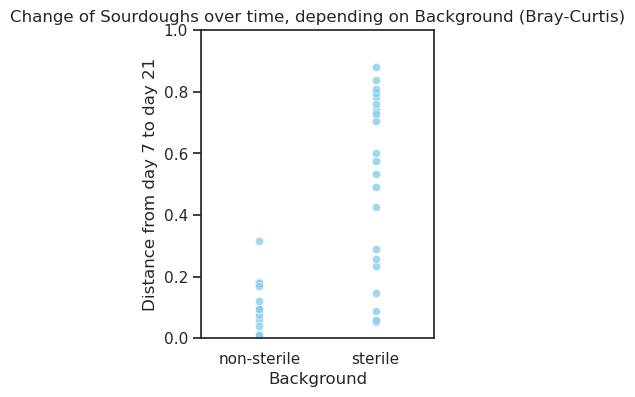

In [19]:
sns.set(rc={'figure.figsize':(3, 4)}, style='white')

with sns.plotting_context("notebook", font_scale=1):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        effect_background_braycurtis, 
        x='Group', 
        y='Distance',
        alpha=0.8,
        color='skyblue')
    
    
    # matplotlib's customization
    ax.set_xlabel('Background')
    ax.set_ylabel('Distance from day 7 to day 21')
    ax.set_ylim((0,1))
    ax.set_xlim(-0.5, 1.5) 

ax.tick_params(axis='y', which='major', left=True)

ax.set_title('Change of Sourdoughs over time, depending on Background (Bray-Curtis)', fontsize=12);

In [13]:
!qiime longitudinal pairwise-distances \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --p-state-column day \
    --p-group-column background \
    --p-state-1 7.0 \
    --p-state-2 21.0 \
    --p-individual-id-column person-id \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv


In [14]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv")

<visualization: Visualization uuid: 54dff10c-0b8d-4e4c-abab-29902ad5822e>

In [20]:
effect_background_jaccard = pd.read_csv(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/pairs-effect-of-background-sourdough-jaccard.tsv', index_col=0, sep='\t')
effect_background_jaccard.shape

(34, 3)

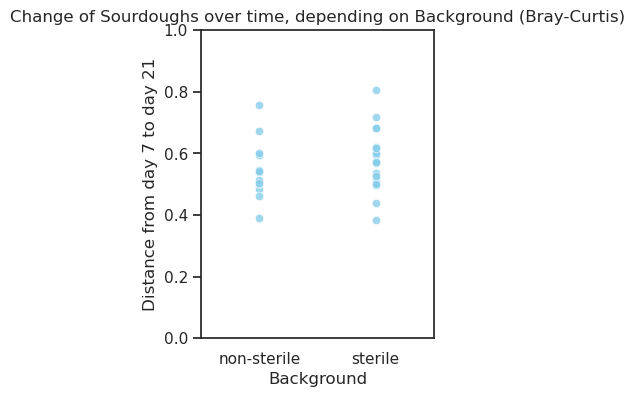

In [21]:
sns.set(rc={'figure.figsize':(3, 4)}, style='white')

with sns.plotting_context("notebook", font_scale=1):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        effect_background_jaccard, 
        x='Group', 
        y='Distance',
        alpha=0.8,
        color='skyblue')
    
    
    # matplotlib's customization
    ax.set_xlabel('Background')
    ax.set_ylabel('Distance from day 7 to day 21')
    ax.set_ylim((0,1))
    ax.set_xlim(-0.5, 1.5) 

ax.tick_params(axis='y', which='major', left=True)

ax.set_title('Change of Sourdoughs over time, depending on Background (Jaccard)', fontsize=12);

<div style="background-color: aliceblue; padding: 10px;">
    
There is a highly significant difference in change of the sourdough fungal abundance (significant bray-curtis (P-value: 0.000301)), but not in composition (non-significant jaccard) over time, depending on the background. 
There are samples also for the sterile background that also almost didn't change and some that did change a lot.

### Effect of latitude & longitude

Bray-curtis

In [22]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --p-formula "latitude*longitude" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_location.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_location.qzv


In [23]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_location.qzv")

<visualization: Visualization uuid: 2dd6113f-f5c8-49c3-a73d-42977cc59fad>

Jaccard

In [24]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --p-formula "latitude*longitude" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_location.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_location.qzv


In [25]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_location.qzv")

<visualization: Visualization uuid: aa8fe1f0-988c-4f17-9866-69a2f811b061>

<div style="background-color: aliceblue; padding: 10px;">

- geographical location doesn't explain difference in abundance & composition of the sourdough's  
- but as they all go to the same highschool, makes sense

### Effect of pets

Fill in NaN's for 0 because adonis can't work with NaN's and we already have just the metadata for people who filled out the survey

In [26]:
df = pd.read_csv("Data/raw/merged_output_usable.tsv", sep="\t")

columns_to_check = ["guinea_pig", "cat", "dog", "turtle", "fish"]

df[columns_to_check] = df[columns_to_check].fillna(0.0)
df.to_csv("Data/diversity/filtered-metadata/meta_pets.tsv", sep="\t", index=False)

Bray curtis (no need to filter distance matrix, as same as before (survey))

In [27]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_pets.tsv  \
    --p-formula "guinea_pig*cat*dog*turtle*fish" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_pets.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_pets.qzv


In [28]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_pets.qzv")

<visualization: Visualization uuid: c0ed1f84-8f2b-456b-84fb-71338acabba7>

Jaccard (no need to filter distance matrix, as same as before (survey))

In [29]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_pets.tsv  \
    --p-formula "guinea_pig*cat*dog*turtle*fish" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_pets.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_pets.qzv


In [30]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_pets.qzv")

<visualization: Visualization uuid: 19c8412d-8581-4583-b8ef-8f1bef138b0d>

<div style="background-color: aliceblue; padding: 10px;">

Pets do not have an influence on fungal composition or abundance

## Analysis of filtered only Hand metadata
<div style="background-color: skyblue; padding: 10px;">


### Initial plots

In [31]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged-hand-only/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: 1d2a7760-bdc0-4178-a1a9-56cda4bfd420>

In [32]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/scatterplot.qzv")

<visualization: Visualization uuid: 9af8a0ba-0668-4f99-8939-f3668ed88c58>

<div style="background-color: aliceblue; padding: 10px;">  
    
- no difference of sourdoughbackground on hand fungal composition visible  
- slight clustering based on aromas of day 21 (e.g. animal stable, beer, berries, chickpea)  
- bread & buttermilk aromas on day 21 are the same, on the other days similar but not the same
- there doesn't seem to be a correlation between yeast / sourdough bake experience and hand fungal composition

### Comparison of handedness

Bray-Curtis

In [33]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-hand-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
    --m-metadata-column hand \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-hand-only/bray_curtis-hand-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-hand-only/bray_curtis-hand-significance.qzv


In [34]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/bray_curtis-hand-significance.qzv")

<visualization: Visualization uuid: 85970df9-c172-4664-8690-ed55b9015c0f>

Jaccard

In [35]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-hand-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
    --m-metadata-column hand \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-hand-only/jaccard-hand-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-hand-only/jaccard-hand-significance.qzv


In [36]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/jaccard-hand-significance.qzv")

<visualization: Visualization uuid: f2e4878f-fdbe-492f-ab0c-42afffc86774>

<div style="background-color: aliceblue; padding: 10px;">

- there is no difference in abundance or composition between right & left hand
- Bray-Curtis: p & q value: 0.876, pseudo F-value: 0.715672
- Jaccard: p & q value: 0.58 and pseude F-value: 0.964955